In [2]:
import requests
import json
import pandas as pd
import os
from requests.auth import HTTPBasicAuth
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import seaborn as sns

## Import query data from Clickhouse

In [3]:
retention_df = pd.read_csv('game_retention_all_2024-10-07.csv')
retention_df.head()

,date,universe_id,root_place_id,total_new_players_d1,returning_players_d1,retention_d1,total_new_players_d7,returning_players_d7,retention_d7,total_new_players_d30,returning_players_d30,retention_d30
0,2024-09-29,0,0,160427,1,0.000623,0,0,0.000000,0,0,0.000000
1,2024-09-29,47545,192800,40543,4796,11.829416,48481,2057,4.242899,32173,413,1.283685
2,2024-09-29,65241,189707,33316,2818,8.458398,51194,1898,3.707466,32855,566,1.722721
3,2024-09-29,2471084,13822889,3584,721,20.117188,5491,412,7.503187,2265,29,1.280353
4,2024-09-29,8726258,11970456,7853,643,8.187954,11312,197,1.741513,6146,56,0.911162


In [4]:
print(retention_df.shape)
# print(retention_df.describe)

(241378, 12)


In [5]:
min(retention_df['date'])

'2024-08-19'

In [6]:
stickiness_df = pd.read_csv('stickiness_2024-10-07.csv')
stickiness_df.head()

,date,universe_id,root_place_id,total_players_d1,returning_players_d1,stickiness_d1,total_players_d7,returning_players_d7,stickiness_d7,total_players_d30,returning_players_d30,stickiness_d30
0,2024-09-29,0,0,160427,1,0.000623,0,0,0.000000,0,0,0.0
1,2024-09-06,13058,1818,71,9,12.676056,100,5,5.000000,0,0,0.0
2,2024-09-07,13058,1818,98,11,11.224490,110,5,4.545455,0,0,0.0
3,2024-09-06,13092,3925,1,1,100.000000,2,1,50.000000,0,0,0.0
4,2024-09-07,13092,3925,1,1,100.000000,1,1,100.000000,0,0,0.0


In [7]:
print(stickiness_df.shape)

(35341, 12)


In [8]:
game_metrics_df = pd.read_csv('game_metrics.csv')
print(game_metrics_df.head())
print(game_metrics_df.shape)

   universe_id  max(playing)  min(playing)  min(like_ratio)  max(like_ratio)
0   4456957884           123             1        65.783134        66.666664
1   4510307444           123             2        79.638596        79.845215
2   6211467409           135             4        90.180590        90.575660
3   5812234034           296             4        66.210045        66.780820
4   6123841740           117            11        93.941864        94.209465
(24302, 5)


In [9]:
genre = pd.read_csv('genre.csv', encoding='utf-8')
print(genre.head())
print(genre.shape)

  universe_id          genre
0       13058       Fighting
1       13092            All
2       47545  Town and City
3       51844            All
4       65241            All
(42846, 2)


In [10]:
# Create df for DAU
dau = pd.read_csv('daily_active_users_2024-10-13.csv')
print(dau.head())

         date  universe_id  root_place_id     dau  new_users  returning_users
0  2024-10-01        47545         192800  564163     410700           153463
1  2024-10-02        47545         192800  500954     384771           116183
2  2024-10-03        47545         192800  455249     384329            70920
3  2024-10-04        47545         192800  504589     504589                0
4  2024-10-05        47545         192800  668536     650378            18158


## Create DF for model

In [11]:
# Combine retention df and DAU df
merged_df = pd.merge(
    retention_df, 
    dau[['date', 'universe_id', 'root_place_id', 'dau']],
    on=['date', 'universe_id', 'root_place_id'],
    how='left'
)

# Remove duplicates from genre, keeping only the first occurrence
genre_unique = genre.drop_duplicates(subset='universe_id')

# Ensure 'universe_id' is of the same type in all DataFrames
merged_df['universe_id'] = merged_df['universe_id'].astype(str)
genre_unique['universe_id'] = genre_unique['universe_id'].astype(str)
game_metrics_df['universe_id'] = game_metrics_df['universe_id'].astype(str)
stickiness_df['universe_id'] = stickiness_df['universe_id'].astype(str)

# Merge with the genre DataFrame
model_data = pd.merge(
    merged_df,
    genre_unique[['universe_id', 'genre']],
    on='universe_id',
    how='left'
)

# Merge with game_metrics_df to add min(like_ratio) and max(like_ratio)
model_data = pd.merge(
    model_data,
    game_metrics_df[['universe_id', 'min(like_ratio)', 'max(like_ratio)']],
    on='universe_id',
    how='left'
)

# Merge with stickiness_df to add stickiness columns
model_data = pd.merge(
    model_data,
    stickiness_df[['date', 'universe_id', 'root_place_id', 'stickiness_d1', 'stickiness_d7', 'stickiness_d30']],
    on=['date', 'universe_id', 'root_place_id'],
    how='left'
)

model_data.head()

/var/folders/gw/s1_67f755hld2_g983ssmt2w0000gn/T/ipykernel_15054/2494109323.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_unique['universe_id'] = genre_unique['universe_id'].astype(str)


,date,universe_id,root_place_id,total_new_players_d1,returning_players_d1,retention_d1,total_new_players_d7,returning_players_d7,retention_d7,total_new_players_d30,returning_players_d30,retention_d30,dau,genre,min(like_ratio),max(like_ratio),stickiness_d1,stickiness_d7,stickiness_d30
0,2024-09-29,0,0,160427,1,0.000623,0,0,0.000000,0,0,0.000000,NaN,NaN,NaN,NaN,0.000623,0.000000,0.000000
1,2024-09-29,47545,192800,40543,4796,11.829416,48481,2057,4.242899,32173,413,1.283685,711616.0,Town and City,92.639080,92.641340,18.855108,7.630534,3.844783
2,2024-09-29,65241,189707,33316,2818,8.458398,51194,1898,3.707466,32855,566,1.722721,700818.0,All,90.723250,90.729485,16.635951,8.210206,5.576330
3,2024-09-29,2471084,13822889,3584,721,20.117188,5491,412,7.503187,2265,29,1.280353,83325.0,Adventure,87.692880,87.696870,36.448480,14.204674,7.398186
4,2024-09-29,8726258,11970456,7853,643,8.187954,11312,197,1.741513,6146,56,0.911162,127805.0,Comedy,75.696724,75.715550,10.235490,2.330777,1.410402


In [12]:
model_data.shape

(241378, 19)

## Use K-Means to detect similar patterns

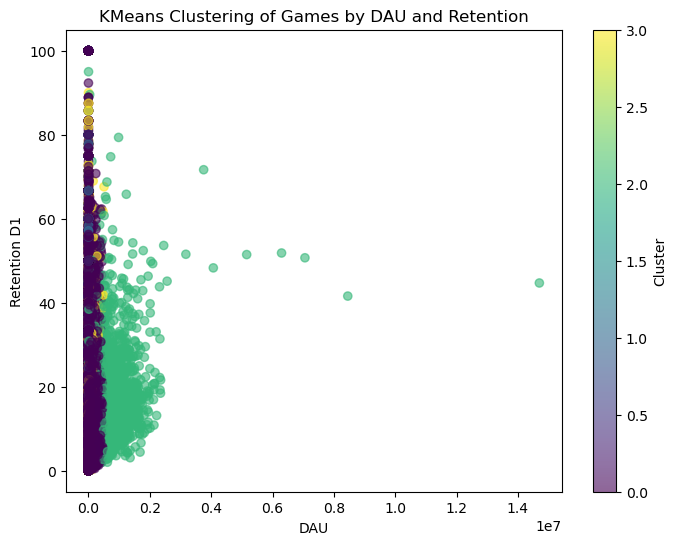

         date universe_id  root_place_id  total_new_players_d1  \
0  2024-09-29           0              0                160427   
1  2024-09-29       47545         192800                 40543   
2  2024-09-29       65241         189707                 33316   
3  2024-09-29     2471084       13822889                  3584   
4  2024-09-29     8726258       11970456                  7853   

   returning_players_d1  retention_d1  total_new_players_d7  \
0                     1      0.000623                     0   
1                  4796     11.829416                 48481   
2                  2818      8.458398                 51194   
3                   721     20.117188                  5491   
4                   643      8.187954                 11312   

   returning_players_d7  retention_d7  total_new_players_d30  ...  \
0                     0      0.000000                      0  ...   
1                  2057      4.242899                  32173  ...   
2                

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# Load your data (assuming it's already in a DataFrame called 'model_data')
data = model_data.copy()

# Select relevant columns for clustering (e.g., 'dau', 'retention_d1', 'retention_d7', 'retention_d30')
# Handle missing values (fill NaN with 0 for simplicity)
data = data.fillna(0)

# Ensure the 'genre' column contains only strings
data['genre'] = data['genre'].astype(str)

# Encode the 'genre' column
encoder = LabelEncoder()
data['genre_encoded'] = encoder.fit_transform(data['genre'])

# Select features for clustering
X = data[['dau', 'retention_d1', 'retention_d7', 'retention_d30', 'genre_encoded']]

# Standardize the features (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose the number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the KMeans model
kmeans.fit(X_scaled)

# Add the cluster labels to the original DataFrame
data['cluster'] = kmeans.labels_

# Visualize the clusters (2D scatter plot with 'dau' and 'retention_d1')
plt.figure(figsize=(8, 6))
plt.scatter(data['dau'], data['retention_d1'], c=data['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('DAU')
plt.ylabel('Retention D1')
plt.title('KMeans Clustering of Games by DAU and Retention')
plt.colorbar(label='Cluster')
plt.show()

# Display the data with clusters
print(data.head())

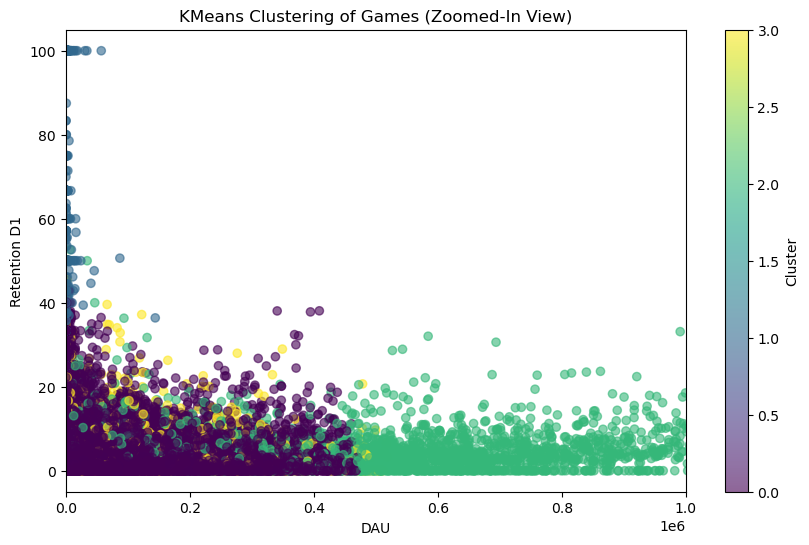

In [14]:
# zooming in 
plt.figure(figsize=(10, 6))
plt.scatter(data['dau'], data['retention_d7'], c=data['cluster'], cmap='viridis', alpha=0.6)
plt.xlim(0, 1e6)  # Limit DAU to a max of 1 million 
# plt.ylim(0, 90)   # Limit retention D1 to a max of 50%

# Add labels and title
plt.xlabel('DAU')
plt.ylabel('Retention D1')
plt.title('KMeans Clustering of Games (Zoomed-In View)')
plt.colorbar(label='Cluster')

# Show the plot
plt.show()

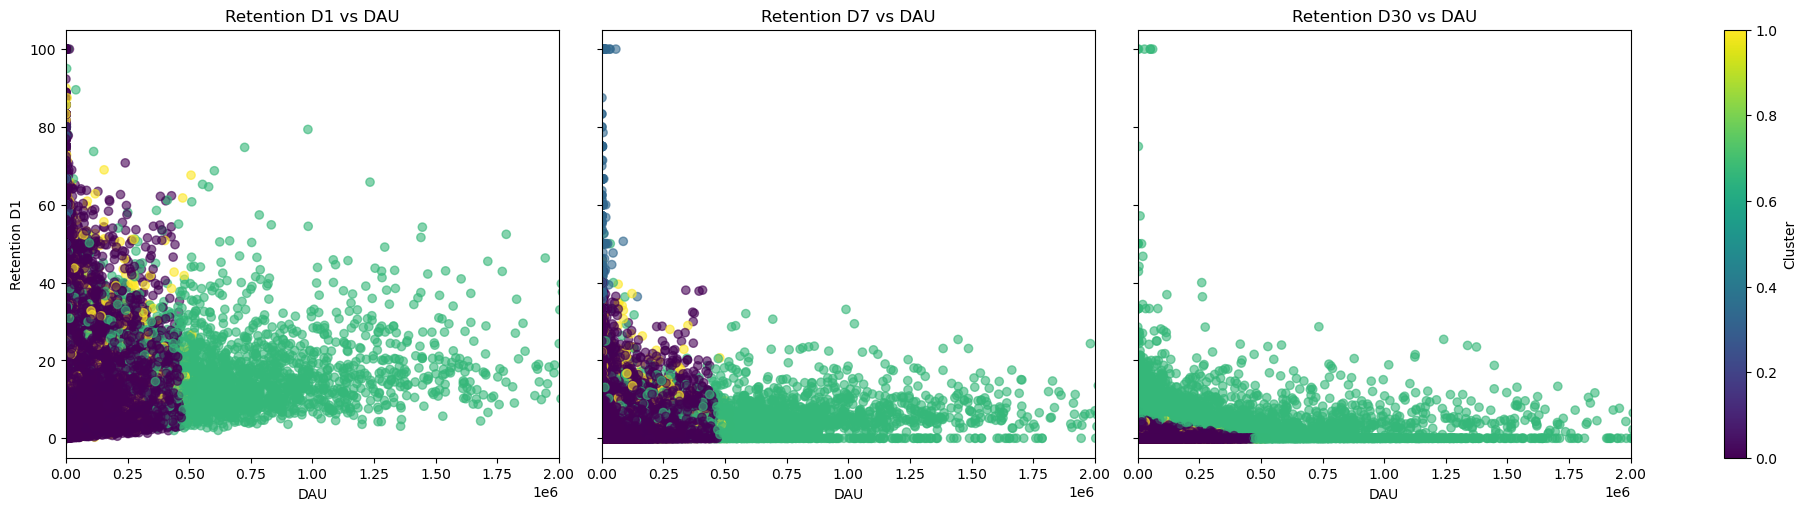

In [15]:
# Zooming in all 3 retention clusters
# Adjust the figure size for better layout and enable constrained layout
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, constrained_layout=True)

# Plot 1: Retention D1
axes[0].scatter(data['dau'], data['retention_d1'], c=data['cluster'], cmap='viridis', alpha=0.6)
axes[0].set_title('Retention D1 vs DAU')
axes[0].set_xlabel('DAU')
axes[0].set_ylabel('Retention D1')
axes[0].set_xlim(0, 2e6)
# axes[0].set_ylim(0, 50)

# Plot 2: Retention D7
axes[1].scatter(data['dau'], data['retention_d7'], c=data['cluster'], cmap='viridis', alpha=0.6)
axes[1].set_title('Retention D7 vs DAU')
axes[1].set_xlabel('DAU')
axes[1].set_xlim(0, 2e6)

# Plot 3: Retention D30
axes[2].scatter(data['dau'], data['retention_d30'], c=data['cluster'], cmap='viridis', alpha=0.6)
axes[2].set_title('Retention D30 vs DAU')
axes[2].set_xlabel('DAU')
axes[2].set_xlim(0, 2e6)

# Add a colorbar to indicate clusters
fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes, location='right', label='Cluster')

# Display the plots
plt.show()

Cluster-Genre Table:


cluster,0,1,2,3
genre,,,,
0,238.0,10.0,2.0,0.0
Adventure,36264.0,877.0,700.0,0.0
All,117189.0,4956.0,1368.0,0.0
Building,4526.0,191.0,24.0,0.0
Comedy,6042.0,155.0,99.0,0.0
FPS,3765.0,97.0,129.0,0.0
Fighting,16095.0,417.0,669.0,252.0
Horror,12333.0,510.0,301.0,1641.0
Medieval,0.0,33.0,0.0,482.0


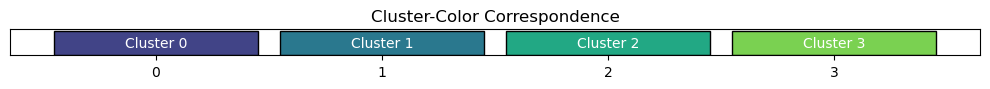

In [16]:
# Group by cluster and genre to see the counts
cluster_genre_table = data.groupby(['cluster', 'genre']).size().reset_index(name='count')

# Pivot the table to make clusters the columns
cluster_pivot = cluster_genre_table.pivot(index='genre', columns='cluster', values='count').fillna(0)

# Display the pivot table in Jupyter
from IPython.display import display
print("Cluster-Genre Table:")
display(cluster_pivot)

# Create a color palette matching the number of clusters
num_clusters = len(cluster_genre_table['cluster'].unique())
palette = sns.color_palette('viridis', num_clusters)

# Plot the color legend corresponding to clusters horizontally
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust the width based on clusters

for idx, cluster in enumerate(cluster_pivot.columns):
    ax.bar(
        idx, 1, color=palette[idx], edgecolor='black', width=0.9
    )
    ax.text(idx, 0.5, f'Cluster {cluster}', va='center', ha='center', color='white')

ax.set_yticks([])
ax.set_xticks(range(num_clusters))
ax.set_xticklabels(cluster_pivot.columns)
ax.set_title('Cluster-Color Correspondence')

plt.tight_layout()
plt.show()

## Top Revenue Games EDA

In [18]:
# Pulled back metadata for top Revenue games only (per file Roblox Revenue estimates for top games 8.29.24)
top_rev_meta = pd.read_csv('topRev.csv')
top_rev_meta.head()

,date,universe_id,root_place_id,name,description,icon_url,creator,created,updated,max_players,universe_avatar_type,genre,genre_l1,genre_l2
0,2023-12-10,994732206,2753915549,Blox Fruits,Holiday Update Part 1 included: Mythical T-Rex...,https://tr.rbxcdn.com/9225b6e423d089c48805f6ce...,"{""id"":""4372130"",""name"":""Gamer Robot Inc"",""type...",2019-01-16 03:29:19,2024-07-03 08:43:17,12,MorphToR15,Adventure,NaN,NaN
1,2023-12-11,994732206,2753915549,Blox Fruits,Holiday Update Part 1 included: Mythical T-Rex...,https://tr.rbxcdn.com/9225b6e423d089c48805f6ce...,"{""id"":""4372130"",""name"":""Gamer Robot Inc"",""type...",2019-01-16 03:29:19,2024-07-03 08:43:17,12,MorphToR15,Adventure,NaN,NaN
2,2023-12-12,994732206,2753915549,Blox Fruits,Holiday Update Part 1 included: Mythical T-Rex...,https://tr.rbxcdn.com/9225b6e423d089c48805f6ce...,"{""id"":""4372130"",""name"":""Gamer Robot Inc"",""type...",2019-01-16 03:29:19,2024-07-03 08:43:17,12,MorphToR15,Adventure,NaN,NaN
3,2023-12-13,994732206,2753915549,Blox Fruits,Holiday Update Part 1 included: Mythical T-Rex...,https://tr.rbxcdn.com/9225b6e423d089c48805f6ce...,"{""id"":""4372130"",""name"":""Gamer Robot Inc"",""type...",2019-01-16 03:29:19,2024-07-03 08:43:17,12,MorphToR15,Adventure,NaN,NaN
4,2023-12-14,994732206,2753915549,Blox Fruits,Holiday Update Part 1 included: Mythical T-Rex...,https://tr.rbxcdn.com/9225b6e423d089c48805f6ce...,"{""id"":""4372130"",""name"":""Gamer Robot Inc"",""type...",2019-01-16 03:29:19,2024-07-03 08:43:17,12,MorphToR15,Adventure,NaN,NaN


In [19]:
print(top_rev_meta.shape)

(953, 14)


In [20]:
print(top_rev_meta.describe())

        universe_id  root_place_id  max_players
count  9.530000e+02   9.530000e+02   953.000000
mean   4.234892e+08   1.131009e+09    15.781742
std    4.189693e+08   1.184681e+09    10.072980
min    6.665414e+07   1.428233e+08    12.000000
25%    6.665414e+07   1.428233e+08    12.000000
50%    8.807056e+07   1.856551e+08    12.000000
75%    9.947322e+08   2.753916e+09    12.000000
max    9.947322e+08   2.753916e+09    48.000000


In [21]:
print(top_rev_meta.dtypes)

date                    object
universe_id              int64
root_place_id            int64
name                    object
description             object
icon_url                object
creator                 object
created                 object
updated                 object
max_players              int64
universe_avatar_type    object
genre                   object
genre_l1                object
genre_l2                object
dtype: object


<Axes: title={'center': 'Activity Over Time'}, xlabel='date'>

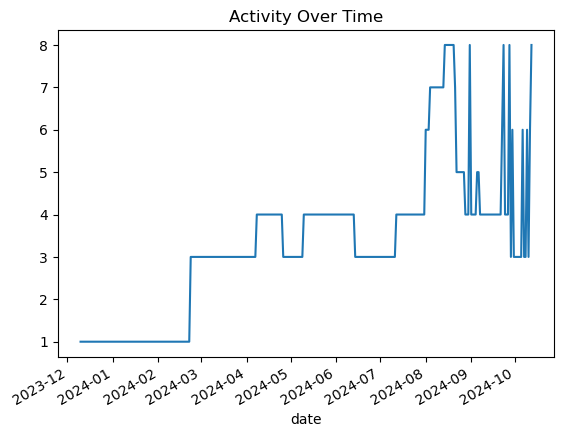

In [22]:
top_rev_meta['date'] = pd.to_datetime(top_rev_meta['date'])  # Convert to datetime
top_rev_meta.groupby('date').size().plot(kind='line', title='Activity Over Time')

In [23]:
top_rev_meta['day_of_week'] = top_rev_meta['date'].dt.day_name()
print(top_rev_meta['day_of_week'].value_counts())

day_of_week
Friday       141
Saturday     141
Wednesday    138
Monday       136
Sunday       133
Tuesday      132
Thursday     132
Name: count, dtype: int64


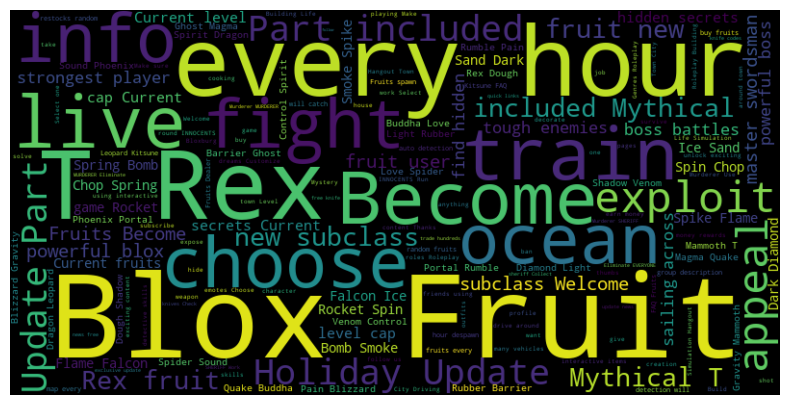

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(top_rev_meta['description'].values)
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

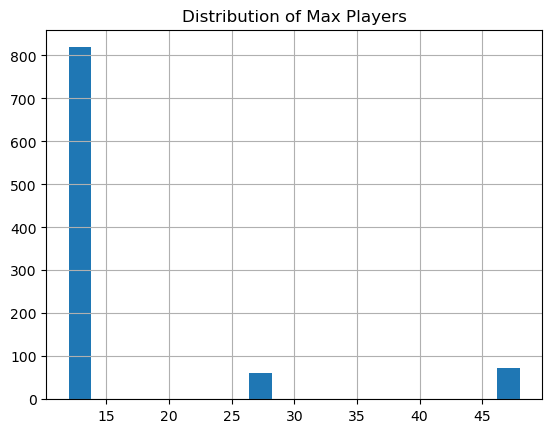

In [46]:
top_rev_meta['max_players'].hist(bins=20)
plt.title('Distribution of Max Players')
plt.show()

### Linear Model

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

### Predict total new players d1

In [25]:
# Define the features (X) and the target variable (y)
X = model_data[['dau', 'retention_d1', 'retention_d7', 'retention_d30','stickiness_d1', 'stickiness_d7', 'stickiness_d30','min(like_ratio)', 'max(like_ratio)']]
y = model_data['total_new_players_d1']

# DATA CLEANING - Drop rows with any NaN values in X or y
X = X.dropna()
y = y[X.index]  # Ensure y aligns with X after dropping NaNs

In [26]:
model_data.shape

(241378, 19)

In [27]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Check the size of each dataset
print(f'Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}')

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Predict on the validation set to evaluate the model
y_val_pred = model.predict(X_val)

# Calculate metrics for validation data
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f'Validation MSE: {mse_val:.2f}')
print(f'Validation R2 Score: {r2_val:.2f}')

# Predict on the test data
y_test_pred = model.predict(X_test)

# Calculate metrics for test data
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Test MSE: {mse_test:.2f}')
print(f'Test R2 Score: {r2_test:.2f}')

Training set size: (20539, 9), Validation set size: (5135, 9), Test set size: (6419, 9)
Validation MSE: 12705392.89
Validation R2 Score: 0.75
Test MSE: 11463510.91
Test R2 Score: 0.76


#### Explanation of data splits
1. Training Data (70-80% of the data)
This is what the model learns from, the model practices on this data to understand the patterns.
2. Validation Data (10-20% of the data)
This is used to check how well the model is doing during training, if the model starts doing badly on validation data, it means it might be overfitting (memorizing too much from the training data without generalizing).
3. Test Data (10-20% of the data)
This is completely new data that the model hasn’t seen before.

#### Key Takeaways:
Model performance is solid:
Both the validation and test R² scores are above 0.75, meaning the model explains most of the variance in the target variable.
The Test MSE being slightly lower than the Validation MSE suggests that the model is not overfitting and generalizes well.

    NOTE - this model already knows a lot of info on d1, d7, d30 data to come up with new playet on D1 info
    
Can drive improvement by

1) adding additional features or 
2) creating interaction terms
3) try non-linear models such as random forests 

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Compare predictions with true values
comparison_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
print(comparison_df.head(20))

         True     Predicted
197415    102   1344.258632
193845     81   1332.387840
178061      1   2440.235735
97306      30   1030.050361
47403    7423   5617.137840
80939      17   1563.500634
62480       6    982.363195
47631      40   1568.184569
115691    508   1087.021500
226703   1615   2133.665161
212368      3   2137.991992
52098     282   -332.229824
128591     94   1350.589101
47770    2134   1362.842322
37510   24348  41530.673338
44633   11504   8214.070122
211791   1674   1820.449983
48827    8975   6088.175464
148796    227   1157.651079
116242     11    689.953806


### Forecasting retention_d30

In [76]:
# Define the features (X_retd30) and the target variable (y_retd30)
X_retd30 = model_data[['dau', 'retention_d1', 'retention_d7', 
                       'stickiness_d1', 'stickiness_d7', 'min(like_ratio)', 'max(like_ratio)']]  # Features (excluding retention_d30 and stickiness_d30)
y_retd30 = model_data['stickiness_d30']  # Target is stickiness_d30

# DATA CLEANING - Drop rows with any NaN values in X_retd30 or y_retd30
X_retd30 = X_retd30.dropna()
y_retd30 = y_retd30[X_retd30.index]  # Ensure y aligns with X after dropping NaNs

In [77]:
# Split the data into training and testing sets (80% train, 20% test)
X_train_retd30, X_test_retd30, y_train_retd30, y_test_retd30 = train_test_split(
    X_retd30, y_retd30, test_size=0.2, random_state=42
)

# Further split training data into training and validation sets (80% train, 20% validation)
X_train_retd30, X_val_retd30, y_train_retd30, y_val_retd30 = train_test_split(
    X_train_retd30, y_train_retd30, test_size=0.2, random_state=42
)

# Check the size of each dataset
print(f'Training set size: {X_train_retd30.shape}, Validation set size: {X_val_retd30.shape}, Test set size: {X_test_retd30.shape}')

# Initialize the Linear Regression model
model_retd30 = LinearRegression()

# Train the model using the training data
model_retd30.fit(X_train_retd30, y_train_retd30)

# Predict on the validation set to evaluate the model
y_val_pred_retd30 = model_retd30.predict(X_val_retd30)

# Calculate metrics for validation data
mse_val_retd30 = mean_squared_error(y_val_retd30, y_val_pred_retd30)
r2_val_retd30 = r2_score(y_val_retd30, y_val_pred_retd30)

print(f'Validation MSE: {mse_val_retd30:.2f}')
print(f'Validation R2 Score: {r2_val_retd30:.2f}')

# Predict on the test data
y_test_pred_retd30 = model_retd30.predict(X_test_retd30)

# Calculate metrics for test data
mse_test_retd30 = mean_squared_error(y_test_retd30, y_test_pred_retd30)
r2_test_retd30 = r2_score(y_test_retd30, y_test_pred_retd30)

print(f'Test MSE: {mse_test_retd30:.2f}')
print(f'Test R2 Score: {r2_test_retd30:.2f}')

Training set size: (20539, 7), Validation set size: (5135, 7), Test set size: (6419, 7)
Validation MSE: 12.68
Validation R2 Score: 0.32
Test MSE: 13.72
Test R2 Score: 0.37


### Notes on Model Performance:
The R² scores around 0.32–0.37 suggest that the current features (e.g., DAU, 7-day retention, stickiness, like ratios) contribute somewhat to predicting 30-day stickiness but leave much of the variability unexplained.

    Potential Areas for Improvement:
* Try non-linear model: Random Forest or Gradient Boosting could capture more complex relationships.
* Feature Engineering: Add interaction terms or other useful metrics.
* Handling Time-Series Data: Stickiness over time might require time-series models or LSTMs.

### Incorporate Genre as a variable

## Non-linear model: Random Forests

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the validation and test sets
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate the metrics for validation and test sets
val_mse_rf = mean_squared_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)

test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

# Display the results
print(f"Validation MSE (Random Forest): {val_mse_rf:.2f}, Validation R² Score: {val_r2_rf:.2f}")
print(f"Test MSE (Random Forest): {test_mse_rf:.2f}, Test R² Score: {test_r2_rf:.2f}")


Validation MSE (Random Forest): 5277656.47, Validation R² Score: 0.90
Test MSE (Random Forest): 4559471.69, Test R² Score: 0.90


In [30]:
# Define the features (X_rf) and target variable (y_rf)
X_rf = model_data.dropna(subset=['stickiness_d30'])  # Ensure no NaNs in target
y_rf = X_rf['stickiness_d30']  # Target variable
X_rf = X_rf[['dau', 'retention_d1', 'retention_d7',  
             'stickiness_d1', 'stickiness_d7', 'min(like_ratio)', 'max(like_ratio)'] 
            + [col for col in model_data.columns if col.startswith('genre_')]]  # Features with genres

# Split the data into training and testing sets (80% train, 20% test)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

# Further split training data into training and validation sets (80% train, 20% validation)
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
    X_train_rf, y_train_rf, test_size=0.2, random_state=42
)

# Check the size of each dataset
print(f'Training set size: {X_train_rf.shape}, Validation set size: {X_val_rf.shape}, Test set size: {X_test_rf.shape}')

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model using the training data
rf_model.fit(X_train_rf, y_train_rf)

# Predict on the validation set to evaluate the model
y_val_pred_rf = rf_model.predict(X_val_rf)

# Calculate metrics for validation data
mse_val_rf = mean_squared_error(y_val_rf, y_val_pred_rf)
r2_val_rf = r2_score(y_val_rf, y_val_pred_rf)

print(f'Validation MSE: {mse_val_rf:.2f}')
print(f'Validation R2 Score: {r2_val_rf:.2f}')

# Predict on the test data
y_test_pred_rf = rf_model.predict(X_test_rf)

# Calculate metrics for test data
mse_test_rf = mean_squared_error(y_test_rf, y_test_pred_rf)
r2_test_rf = r2_score(y_test_rf, y_test_pred_rf)

print(f'Test MSE: {mse_test_rf:.2f}')
print(f'Test R2 Score: {r2_test_rf:.2f}')

Training set size: (22488, 7), Validation set size: (5622, 7), Test set size: (7028, 7)
Validation MSE: 6.98
Validation R2 Score: 0.67
Test MSE: 5.62
Test R2 Score: 0.69


### Random Forests model results interpretation 
The Random Forest model clearly outperforms the linear regression model by capturing more complex patterns in the data. The R² score of 0.69 shows a strong fit, and the low MSE confirms accurate predictions. We could further enhance this model by:

* Tuning hyperparameters (like n_estimators and max_depth).
* Feature importance analysis to identify which variables contribute the most.

## Real Data CSV files Consolidation

In [60]:
# Define the folder where your CSVs are stored (update the path if needed)
root_folder = '/Users/melodymassis/CreatorExchange/Roblox Real Game Data/'

In [17]:
# Path to the main folder containing game folders and CSVs
main_folder = "/Users/melodymassis/CreatorExchange/Roblox Real Game Data"
output_folder = "/Users/melodymassis/CreatorExchange/Processed Game Data"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Dictionary to store DataFrames by metric (file type)
consolidated_data = {}

# Loop through each game folder and load each CSV
for game_folder in os.listdir(main_folder):
    game_path = os.path.join(main_folder, game_folder)

    if os.path.isdir(game_path):  # Ensure it's a folder
        game_name = game_folder  # Use the folder name as the game name

        # Loop through CSVs in each game folder
        for csv_file in os.listdir(game_path):
            if csv_file.endswith(".csv"):
                csv_path = os.path.join(game_path, csv_file)

                try:
                    # Load the CSV into a DataFrame
                    df = pd.read_csv(csv_path)

                    # Add the game name as a new column
                    df['game_name'] = game_name

                    # Create a new key by concatenating the first two columns and game name
                    new_key = (
                        df.iloc[:, 0].astype(str) + "_" +  # First column (e.g., Breakdown)
                        df.iloc[:, 1].astype(str) + "_" +  # Second column (e.g., Date)
                        game_name
                    )
                    df.insert(0, 'key', new_key)  # Insert 'key' as the first column

                    # Extract the metric name from the CSV filename
                    metric_name = csv_file.split("-", 1)[0].strip()

                    # Add the DataFrame to the consolidated data dictionary
                    if metric_name not in consolidated_data:
                        consolidated_data[metric_name] = []
                    consolidated_data[metric_name].append(df)

                except Exception as e:
                    print(f"Error loading {csv_file} from {game_name}: {e}")

# Merge DataFrames by metric and save to new consolidated files
for metric, df_list in consolidated_data.items():
    merged_df = pd.concat(df_list, ignore_index=True)  # Concatenate all DataFrames
    output_path = os.path.join(output_folder, f"Consolidated_{metric}.csv")
    merged_df.to_csv(output_path, index=False)  # Save the merged DataFrame
    print(f"Saved consolidated data for {metric} to {output_path}")

Saved consolidated data for Day 7 Retention to /Users/melodymassis/CreatorExchange/Processed Game Data/Consolidated_Day 7 Retention.csv
Saved consolidated data for Unique Impressions per Source to /Users/melodymassis/CreatorExchange/Processed Game Data/Consolidated_Unique Impressions per Source.csv
Saved consolidated data for Average Session Time to /Users/melodymassis/CreatorExchange/Processed Game Data/Consolidated_Average Session Time.csv
Saved consolidated data for Daily Revenue to /Users/melodymassis/CreatorExchange/Processed Game Data/Consolidated_Daily Revenue.csv
Saved consolidated data for New and Returning Users to /Users/melodymassis/CreatorExchange/Processed Game Data/Consolidated_New and Returning Users.csv
Saved consolidated data for Daily Active Users to /Users/melodymassis/CreatorExchange/Processed Game Data/Consolidated_Daily Active Users.csv
Saved consolidated data for Returning Users to /Users/melodymassis/CreatorExchange/Processed Game Data/Consolidated_Returning Us

## Real Data EDA

In [31]:
data = pd.read_csv('consolidated_real.csv')
revenue_data = pd.DataFrame(data)
revenue_data.head(25)

,key,Breakdown,Date,Average Session Time,universe_id,game_name,Daily Active Users,Revenue,Day 1 Retention,Day 7 Retention,Day 7 Stickiness,Day 30 Retention,Day 30 Stickiness,Monthly Active Users,Qualified Play Through Rate,Sessions,Playtime,Unique Users with Impressions,returning users
0,Total_2024-06-22T00:00:00.000Z_📎 Sell papercli...,Total,2024-06-22T00:00:00.000Z,20.779665,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,330.00000,643.0,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,261.0,2.0
1,Total_2024-06-23T00:00:00.000Z_📎 Sell papercli...,Total,2024-06-23T00:00:00.000Z,20.924213,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,350.00000,504.0,0.121951,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,505.0,41.0
2,Total_2024-06-24T00:00:00.000Z_📎 Sell papercli...,Total,2024-06-24T00:00:00.000Z,39.984768,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,50.00000,20.0,0.077670,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,299.0,44.0
3,Total_2024-06-25T00:00:00.000Z_📎 Sell papercli...,Total,2024-06-25T00:00:00.000Z,26.103846,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,73.00000,215.0,0.166667,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,199.0,23.0
4,Total_2024-06-26T00:00:00.000Z_📎 Sell papercli...,Total,2024-06-26T00:00:00.000Z,18.404228,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,769.00000,4060.0,0.140000,0.000000,0.000000,0.0,0.0,NaN,0.012669,NaN,NaN,775.0,28.0
5,Total_2024-06-27T00:00:00.000Z_📎 Sell papercli...,Total,2024-06-27T00:00:00.000Z,19.184746,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,438.00000,784.0,0.110661,0.000000,0.000000,0.0,0.0,NaN,0.007353,NaN,NaN,939.0,95.0
6,Total_2024-06-28T00:00:00.000Z_📎 Sell papercli...,Total,2024-06-28T00:00:00.000Z,12.852701,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,2194.00000,3326.0,0.119534,0.000000,0.000000,0.0,0.0,NaN,0.027094,NaN,NaN,2260.0,94.0
7,Total_2024-06-29T00:00:00.000Z_📎 Sell papercli...,Total,2024-06-29T00:00:00.000Z,16.685495,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,5110.00000,7314.0,0.096667,0.006098,0.006061,0.0,0.0,NaN,0.055287,NaN,NaN,5842.0,253.0
8,Total_2024-06-30T00:00:00.000Z_📎 Sell papercli...,Total,2024-06-30T00:00:00.000Z,18.307911,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,5854.00000,15165.0,0.088326,0.009709,0.011429,0.0,0.0,NaN,0.045298,NaN,NaN,8340.0,562.0
9,Total_2024-07-01T00:00:00.000Z_📎 Sell papercli...,Total,2024-07-01T00:00:00.000Z,19.475952,6.106475e+09,📎 Sell paperclips to RULE THE WORLD! 🌎,3786.00000,7469.0,0.091459,0.000000,0.040000,0.0,0.0,NaN,0.043249,NaN,NaN,8117.0,730.0


In [32]:
revenue_data.shape

(2240, 19)

In [33]:
revenue_data['universe_id'].unique()

array([6.10647467e+09, 5.89629441e+09, 6.11868012e+09, 5.32425316e+09,
       5.15659088e+09,            nan, 5.76335809e+09, 2.93875263e+09,
       3.99010655e+09, 5.14340277e+09, 5.08493178e+09])

In [34]:
# Ensure 'Date' is in datetime format
revenue_data['Date'] = pd.to_datetime(revenue_data['Date'])

In [45]:
# Check the date range by universe_id
date_range_by_universe = revenue_data.groupby('universe_id')['Date'].agg(['min', 'max'])

# Display the date range for each universe_id
print(date_range_by_universe)

                                   min                       max
universe_id                                                     
2.938753e+09 2024-04-30 00:00:00+00:00 2024-10-11 00:00:00+00:00
3.990107e+09 2024-05-30 00:00:00+00:00 2024-10-11 00:00:00+00:00
5.084932e+09 2023-11-09 00:00:00+00:00 2024-10-11 00:00:00+00:00
5.143403e+09 2023-10-16 00:00:00+00:00 2024-10-11 00:00:00+00:00
5.156591e+09 2023-11-20 00:00:00+00:00 2024-10-11 00:00:00+00:00
5.324253e+09 2023-12-08 00:00:00+00:00 2024-10-11 00:00:00+00:00
5.763358e+09 2024-03-16 00:00:00+00:00 2024-10-11 00:00:00+00:00
5.896294e+09 2024-06-18 00:00:00+00:00 2024-10-11 00:00:00+00:00
6.106475e+09 2024-06-22 00:00:00+00:00 2024-10-07 00:00:00+00:00
6.118680e+09 2024-06-23 00:00:00+00:00 2024-10-11 00:00:00+00:00


In [46]:
# # Do we need to transform Revenue to be model friendly? If highly skewed then yes.
# # Plot histograms of the original and log-transformed revenue data
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.hist(train_data['Revenue'], bins=50, color='blue', alpha=0.7)
# plt.title('Original Revenue Distribution')
# plt.xlabel('Revenue')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.hist(train_data['log_revenue'], bins=50, color='green', alpha=0.7)
# plt.title('Log-Transformed Revenue Distribution')
# plt.xlabel('Log Revenue')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

Number of duplicate dates: 1878


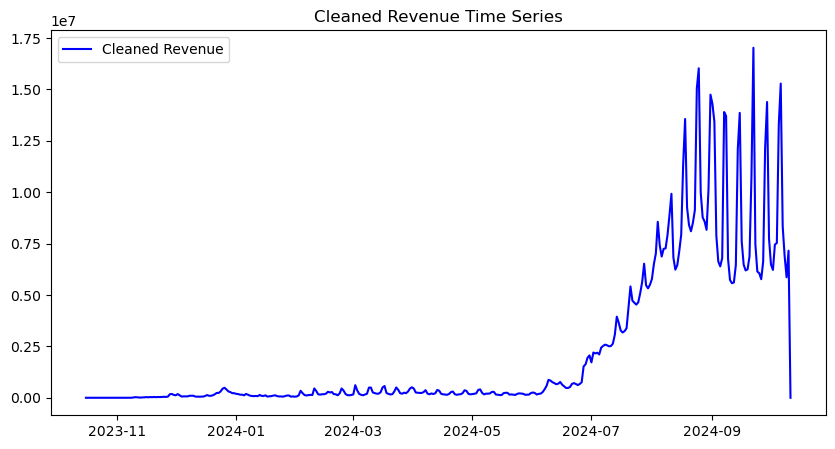

In [53]:
# Ensure 'Date' is in datetime format
revenue_data['Date'] = pd.to_datetime(revenue_data['Date'])

# Check for duplicate dates
duplicate_dates = revenue_data['Date'].duplicated().sum()
print(f"Number of duplicate dates: {duplicate_dates}")

# If duplicates exist, group by 'Date' and aggregate 'Revenue' by sum
if duplicate_dates > 0:
    revenue_ts = revenue_data.groupby('Date')['Revenue'].sum()
else:
    revenue_ts = revenue_data.set_index('Date')['Revenue']

# Ensure the frequency is set to daily and fill any missing dates with 0
revenue_ts = revenue_ts.asfreq('D').fillna(0)

# Plot the cleaned time series
plt.figure(figsize=(10, 5))
plt.plot(revenue_ts, label='Cleaned Revenue', color='blue')
plt.title('Cleaned Revenue Time Series')
plt.legend()
plt.show()

## Time Series Forecasting with Random Forests

Test MSE: 56812125215.73
Test R² Score: -18.84


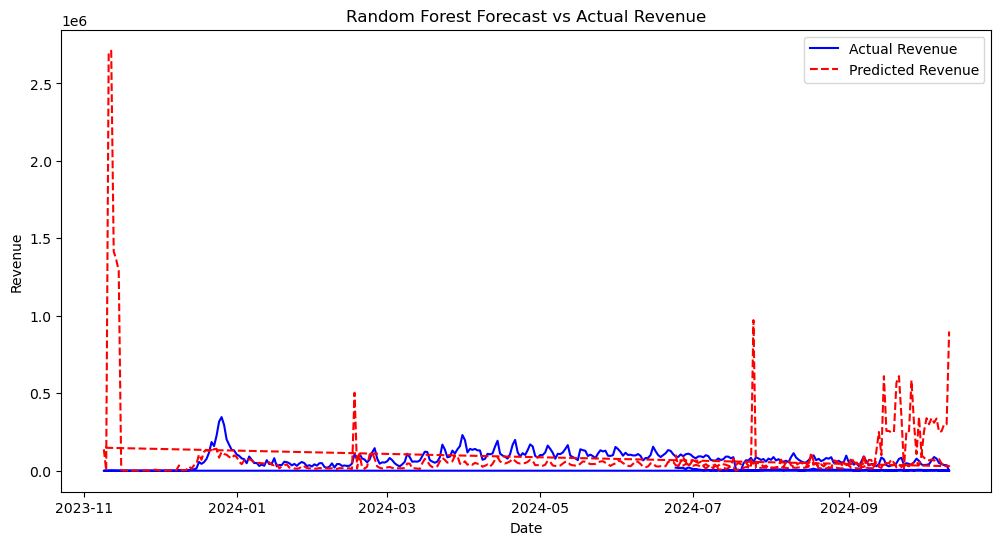

In [83]:
# Merge the time series back to the main DataFrame
revenue_data = revenue_data.set_index('Date').join(revenue_ts, rsuffix='_agg')
revenue_data.reset_index(inplace=True)

# Step 3: Define Features and Target
features = ['Day 1 Retention', 'Day 7 Retention', 'Day 7 Stickiness', 
            'Day 30 Retention', 'Day 30 Stickiness', 'Daily Active Users']

# Ensure no NaNs in the features (fill with 0 if needed)
revenue_data[features] = revenue_data[features].fillna(0)

# Add 'Day_of_Week' as a feature
revenue_data['Day_of_Week'] = revenue_data['Date'].dt.dayofweek

# Define X (features) and y (target)
X = revenue_data[features + ['Day_of_Week']]
y = revenue_data['Revenue']

# Ensure y contains no NaN values
y = y.fillna(0)  # If there are still NaNs, fill them with 0

# Step 4: Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 5: Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Save the model (optional)
joblib.dump(rf_model, 'random_forest_revenue_model.pkl')

# Step 6: Predict on the test set
y_pred = rf_model.predict(X_test)

# Step 7: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse:.2f}')
print(f'Test R² Score: {r2:.2f}')

# Step 8: Create a DataFrame to Compare Actual vs Predicted Revenue
comparison_df = pd.DataFrame({
    'Date': revenue_data['Date'].iloc[len(X_train):].values,
    'Actual Revenue': y_test.values,
    'Predicted Revenue': y_pred
})

# Step 9: Plot Actual vs Predicted Revenue
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual Revenue'], label='Actual Revenue', color='blue')
plt.plot(comparison_df['Date'], comparison_df['Predicted Revenue'], label='Predicted Revenue', color='red', linestyle='dashed')
plt.title('Random Forest Forecast vs Actual Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [129]:
# Remove outliers
# Calculate Q1 and Q3
Q1 = revenue_data['Revenue'].quantile(0.25)
Q3 = revenue_data['Revenue'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers from the revenue data
revenue_data_no_outliers = revenue_data[(revenue_data['Revenue'] >= lower_bound) & (revenue_data['Revenue'] <= upper_bound)]

print(f"Original data size: {revenue_data.shape}")
print(f"Data size after removing outliers: {revenue_data_no_outliers.shape}")

Original data size: (2020, 42)
Data size after removing outliers: (1940, 42)


In [131]:
revenue_data_no_outliers = revenue_data_no_outliers.reset_index()  # Ensure 'Date' is in the columns

# Merge the time series back to the main DataFrame (after removing outliers)
revenue_data_no_outliers = revenue_data_no_outliers.set_index('Date').join(revenue_ts, rsuffix='_agg')
revenue_data_no_outliers.reset_index(inplace=True)  # Reset index to bring 'Date' back as a column

# Step 3: Define Features and Target
features = ['Day 1 Retention', 'Day 7 Retention', 'Day 7 Stickiness', 
            'Day 30 Retention', 'Day 30 Stickiness', 'Daily Active Users', 'returning users', 'Day_of_Week', 'universe_id']
target = 'Revenue'

# Define new cutoff dates to avoid data leakage and apply consistent splits
cutoff_date_train = '2024-04-01'  # End of training set
cutoff_date_val = '2024-08-01'    # End of validation set, start of test set

# Create the training, validation, and test sets using the Date column for cutoff
train_data = revenue_data_no_outliers[revenue_data_no_outliers['Date'] <= cutoff_date_train].copy()
val_data = revenue_data_no_outliers[(revenue_data_no_outliers['Date'] > cutoff_date_train) & (revenue_data_no_outliers['Date'] <= cutoff_date_val)].copy()
test_data = revenue_data_no_outliers[revenue_data_no_outliers['Date'] > cutoff_date_val].copy()

# Define X and y for train, validation, and test sets
X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Step 5: Train the Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Save the model (optional)
joblib.dump(rf_model, 'random_forest_revenue_model.pkl')

# Predict on validation and test sets
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics for validation and test sets
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display metrics
print(f'Validation MSE: {val_mse:.2f}, Validation R² Score: {val_r2:.2f}')
print(f'Test MSE: {test_mse:.2f}, Test R² Score: {test_r2:.2f}')

# Create a DataFrame for comparison between actual vs. predicted for the test set
comparison_df = pd.DataFrame({
    'Date': test_data['Date'].values,
    'universe_id': test_data['universe_id'].values,
    'Actual Revenue': y_test.values,
    'Predicted Revenue': y_test_pred
})

# Calculate the absolute difference and percentage difference between actual and predicted values
comparison_df['Difference'] = abs(comparison_df['Actual Revenue'] - comparison_df['Predicted Revenue'])
comparison_df['% Difference'] = (comparison_df['Difference'] / comparison_df['Actual Revenue'].replace(0, np.nan)) * 100

# Sort by the largest difference to identify spikes
comparison_df_sorted = comparison_df.sort_values(by='Difference', ascending=False)

# Display the sorted DataFrame
comparison_df_sorted

Validation MSE: 772574013.10, Validation R² Score: 0.57
Test MSE: 726663999.29, Test R² Score: 0.22


,Date,universe_id,Actual Revenue,Predicted Revenue,Difference,% Difference
0,2024-08-25,6.106475e+09,140815.0,18856.45,121958.55,86.609062
1,2024-08-26,6.106475e+09,128525.0,18874.97,109650.03,85.314165
42,2024-10-06,6.106475e+09,113191.0,14849.20,98341.80,86.881289
202,2024-09-02,5.324253e+09,117430.0,26116.77,91313.23,77.759712
462,2024-08-29,2.938753e+09,124111.0,34665.52,89445.48,72.068938
...,...,...,...,...,...,...
230,2024-09-30,5.324253e+09,2166.0,2104.62,61.38,2.833795
339,2024-09-11,NaN,447.0,493.77,46.77,10.463087
610,2024-09-10,5.084932e+09,43125.0,43113.93,11.07,0.025670
229,2024-09-29,5.324253e+09,2802.0,2813.01,11.01,0.392934


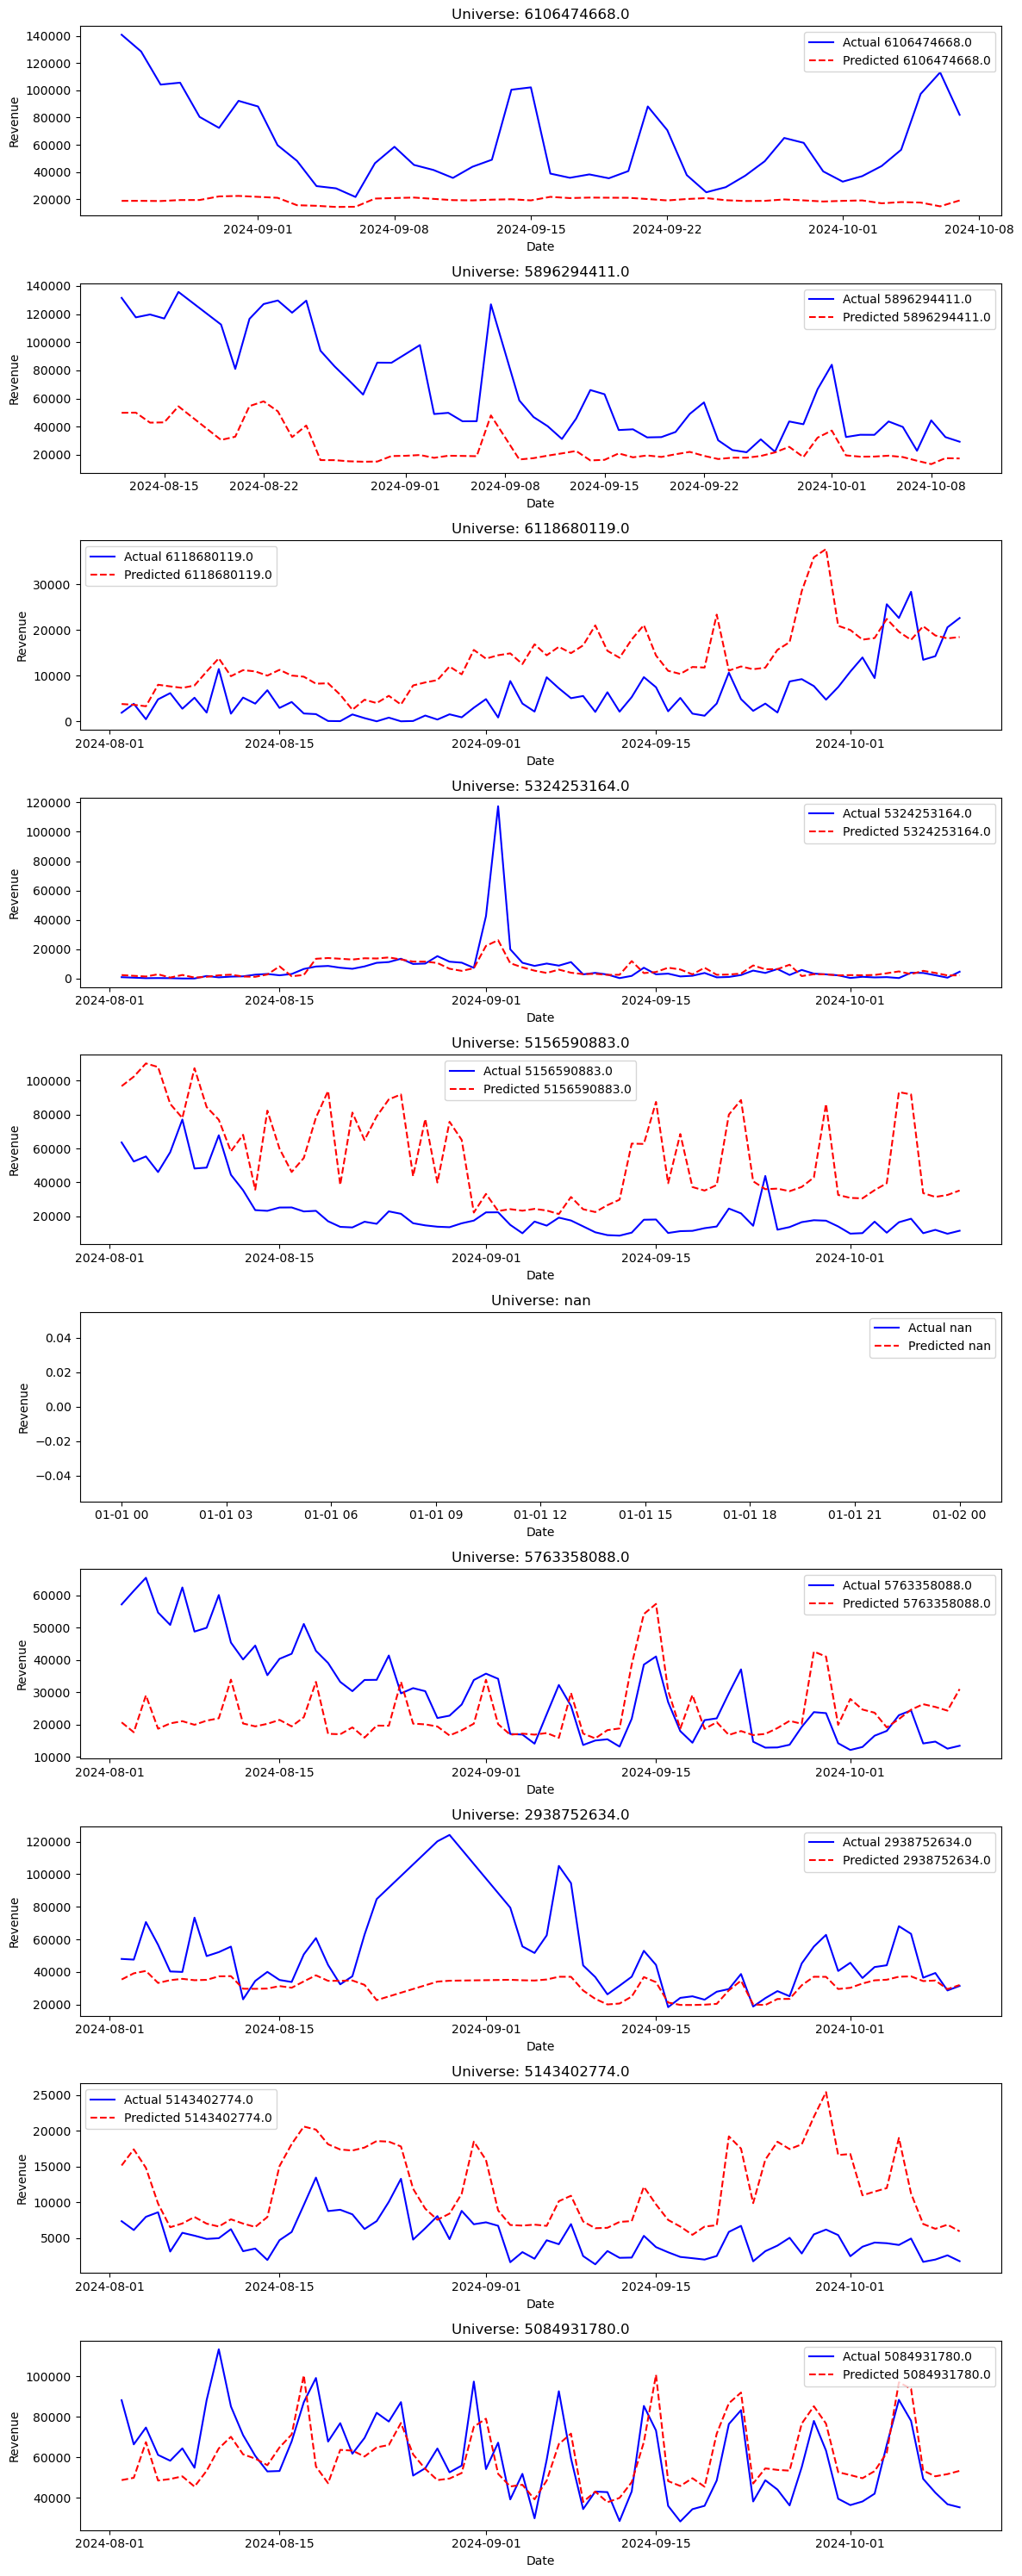

In [132]:
# Unique universes in the test set for plotting
unique_universes = comparison_df['universe_id'].unique()

# Set up subplots
fig, axes = plt.subplots(nrows=len(unique_universes), ncols=1, figsize=(12, len(unique_universes) * 3))

# Ensure `axes` is iterable in case there's only one subplot
if len(unique_universes) == 1:
    axes = [axes]

# Plot actual vs predicted revenue for each universe
for i, universe_id in enumerate(unique_universes):
    universe_data = comparison_df[comparison_df['universe_id'] == universe_id]
    ax = axes[i]
    ax.plot(universe_data['Date'], universe_data['Actual Revenue'], label=f'Actual {universe_id}', color='blue')
    ax.plot(universe_data['Date'], universe_data['Predicted Revenue'], linestyle='dashed', label=f'Predicted {universe_id}', color='red')
    ax.set_title(f'Universe: {universe_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Revenue')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

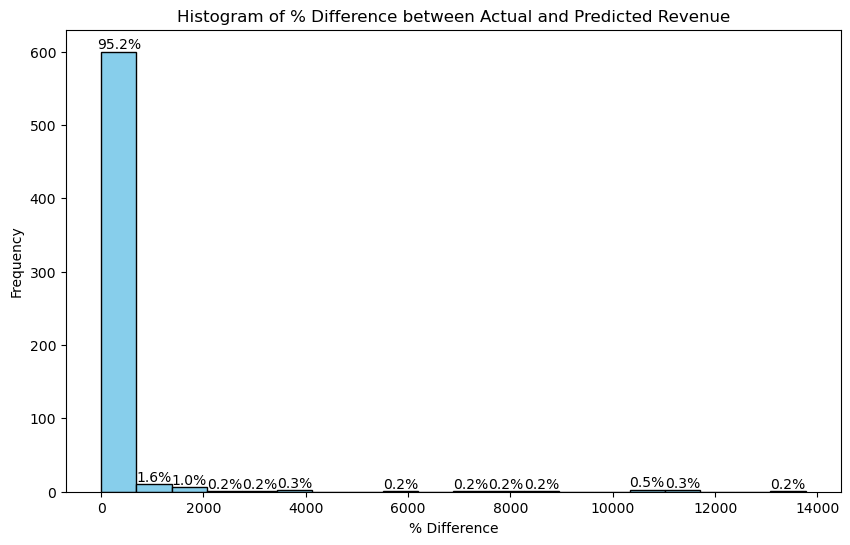

Percentage of rows in the first bin: 95.24%


In [133]:
# Drop any NaN values in % Difference
percent_diff = comparison_df_sorted['% Difference'].dropna()

# Plot histogram of % Difference with 20 bins
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(percent_diff, bins=20, color='skyblue', edgecolor='black')

# Calculate the total number of rows to compute percentages
total = len(percent_diff)

# Annotate each bar with the percentage of the total
for count, patch in zip(counts, patches):
    # Calculate the percentage for this bin
    percentage = (count / total) * 100
    # Get the x position for the text annotation
    x = patch.get_x() + patch.get_width() / 2
    # Only annotate bars with non-zero values
    if percentage > 0:
        plt.text(x, count, f'{percentage:.1f}%', ha='center', va='bottom')

# Add labels and title
plt.title('Histogram of % Difference between Actual and Predicted Revenue')
plt.xlabel('% Difference')
plt.ylabel('Frequency')
plt.show()

# Check if the first bin is the majority
first_bin_percentage = (counts[0] / total) * 100
print(f"Percentage of rows in the first bin: {first_bin_percentage:.2f}%")

### Potential improvements / Transformations

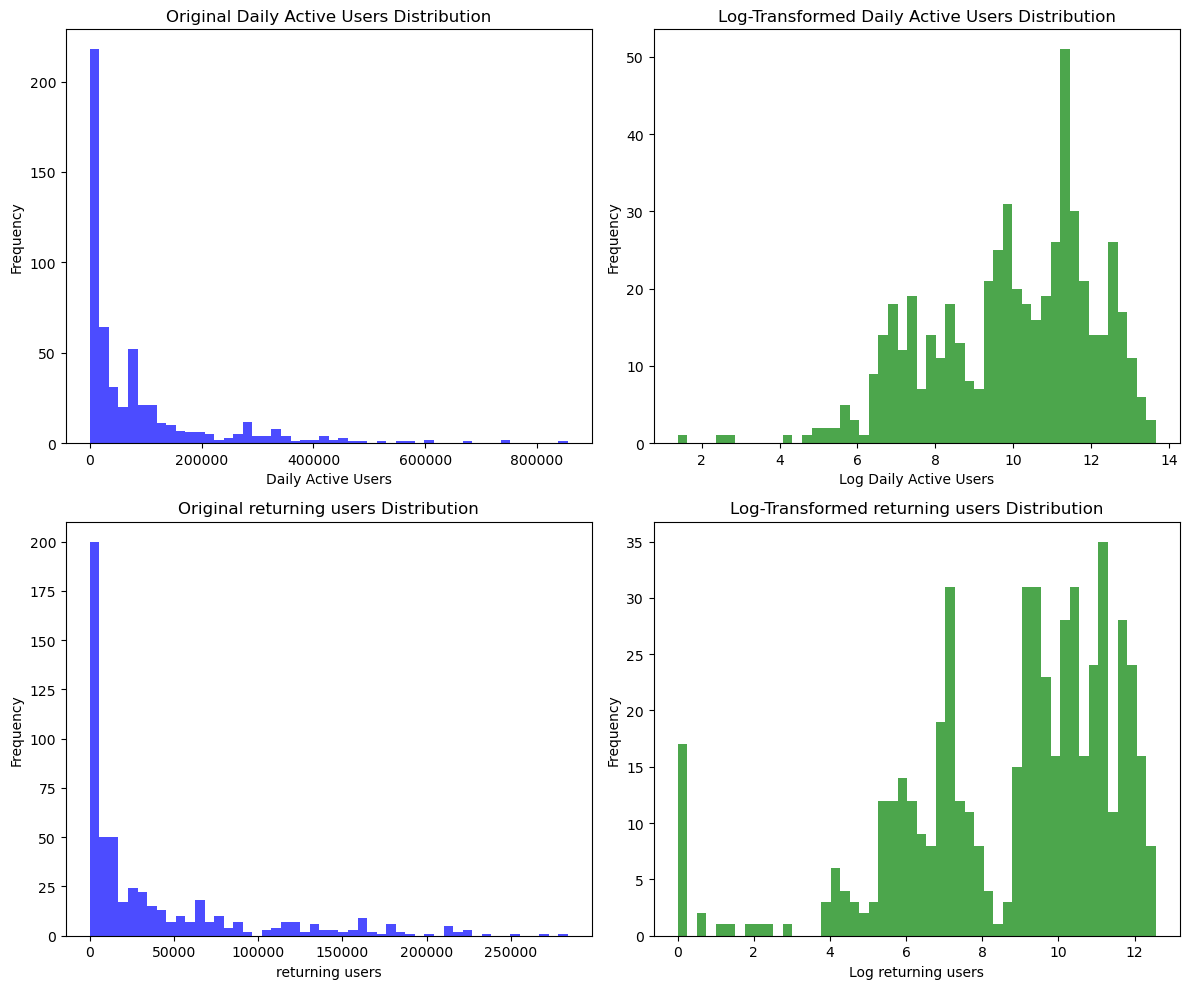

In [134]:
# # Define count-based features you want to transform and plot
count_features = ['Daily Active Users', 'returning users']

# Set up the figure with a grid of subplots
num_features = len(count_features)
plt.figure(figsize=(12, 5 * num_features))

for i, feature in enumerate(count_features):
    # Original distribution
    plt.subplot(num_features, 2, 2 * i + 1)
    plt.hist(train_data[feature], bins=50, color='blue', alpha=0.7)
    plt.title(f'Original {feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
    # Log-transformed distribution (using log1p to handle zeros)
    log_transformed_feature = np.log1p(train_data[feature])
    plt.subplot(num_features, 2, 2 * i + 2)
    plt.hist(log_transformed_feature, bins=50, color='green', alpha=0.7)
    plt.title(f'Log-Transformed {feature} Distribution')
    plt.xlabel(f'Log {feature}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Potential transformation: Transform DAU and Returning Users to Log given the high tailed distribution